# Jitter Fisher Analysis

Telescope jitter will negatively effect an inference algorithm's ability to constrain all its other parameters. In the case of the TOLIMAN telescope, we are primarily concerned with the ability to constrain the binary separation. In this notebook we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters.

First let's configure the notebook.

In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

## Building Model
Here we build our dLux forwards model with parametric jitter. We will model the jitter as a simple harmonic oscillation

In [2]:
oversample = 8
det_pscale = 0.375
det_npixels = 128
kernel_size = 17

jitter_params = {"A": 0.1, "phi": 0}  # these will vary
radial_orders = [2, 3]

In [3]:
src = dlT.AlphaCen()
det = dl.LayeredDetector([
    ('Jitter', dlT.SHMJitter(**jitter_params, kernel_size=kernel_size)),
    ('Downsample', dl.Downsample(oversample)),
])

osys = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_pixel_scale=det_pscale,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    )
osys = osys.divide('aperture.basis', 1e9) # Set basis units to nanometers

telescope = dl.Telescope(source=src, optics=osys, detector=det)

## Visualising the Jitter Parameters
Our jitter parameters are $A$ and $\phi$. $A$ is the amplitude of the sinusoid in pixels, $\phi$ is the angle of the jitter in degrees.

<>:6: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\,'
/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_45520/2879902089.py:6: SyntaxWarning: invalid escape sequence '\,'
  ax0.set(title=f'$A={A}\,as$, $\phi={phi}\,deg$', xlabel='Arcseconds', ylabel='Arcseconds')
/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_45520/2879902089.py:6: SyntaxWarning: invalid escape sequence '\,'
  ax0.set(title=f'$A={A}\,as$, $\phi={phi}\,deg$', xlabel='Arcseconds', ylabel='Arcseconds')


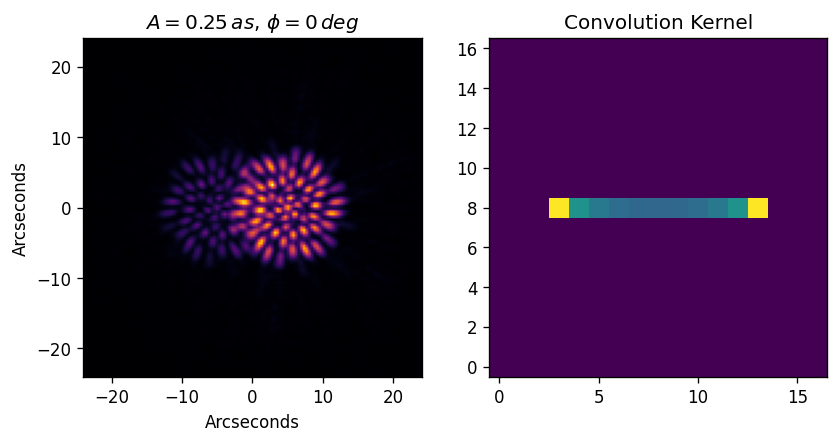

In [4]:
def show_jitter_example(telescope, A, phi):
    example_model = telescope.set(["detector.Jitter.A", "detector.Jitter.phi"], [A, phi])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    img = ax0.imshow(example_model.model(), extent=[-det_npixels/2*det_pscale, det_npixels/2*det_pscale, -det_npixels/2*det_pscale, det_npixels/2*det_pscale])
    ax0.set(title=f'$A={A}\,as$, $\phi={phi}\,deg$', xlabel='Arcseconds', ylabel='Arcseconds')
    c = ax1.imshow(example_model.detector.Jitter.generate_kernel(det_pscale/oversample), cmap='viridis')
    ax1.set(title='Convolution Kernel')
    plt.show()

# show_jitter_example(telescope, 1e-10, 0)
show_jitter_example(telescope, 0.25, 0)
# show_jitter_example(telescope, 2*det_pscale, 90)
# show_jitter_example(telescope, 0.5, 60)

## Fisher Analysis
Now we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters. We will do this by calculating the covariance matrix of the parameters of interest. We will then plot the standard deviation of each parameter as a function of the jitter magnitude.

Specifically we are interested in the `separation` as that is the science signal we aim to extract with TOLIMAN.

Quickly we want to find the separation constraint for a telescope with NO jitter.

In [5]:
jitterless_det = dl.LayeredDetector([
    ('Downsample', dl.Downsample(oversample)),
])
jitterless_telescope = dl.Telescope(source=src, optics=osys, detector=jitterless_det)

# Marginal parameters
jitterless_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',
    'aperture.coefficients',
]

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
# calc_cov = lambda model, parameters: -np.linalg.inv(FIM(model, parameters, zdx.poiss_loglike, model.model(), shape_dict={'wavelengths': 1}))
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike, shape_dict={'wavelengths': 1})
cov_fn = zdx.filter_jit(calc_cov)  # jitting

In [6]:
# jitter_free_baseline = 1000*np.sqrt(np.abs(cov_fn(jitterless_telescope, jitterless_params)[0, 0]))
# print(jitter_free_baseline)

Now, let's loop over our jitter parameters and track how our separation constraint changes.

In [7]:
# Marginal parameters
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
    'Jitter.A',
    'Jitter.phi',
    'aperture.coefficients',
]

# Jitter parameter grid
effect_lim = 0.5 * det_pscale / oversample  # an amplitude any smaller will have no effect at this oversample
As = np.logspace(np.log10(1e-5 + effect_lim), np.log10(1 * det_pscale), 8)
phis = np.linspace(0, 90, 3)

seps = []
for A_idx, A in tqdm(enumerate(As), total=len(As)):
    model = telescope.set("detector.Jitter.A", A)

    for phi_idx, phi in enumerate(phis):        
        model = model.set("detector.Jitter.phi", phi)

        cov = cov_fn(model, params)
        sep = np.sqrt(np.abs(cov[0, 0]))
            
        seps.append(sep)

seps = np.array(seps).reshape(len(As), len(phis))

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Analysis
Let's plot our results. On the horizontal axes here I have plotted "Jitter Excursion" which is double the value of $A$. This is a more physical value as it is the total width of the streak on the detector.

In [ ]:
print("Max recommended kernel_size:", 
    telescope.set("detector.Jitter.A", As.max()).detector.Jitter.optimal_kernel_size(det_pscale/oversample),
)

fig, ax = plt.subplots(figsize=(8, 4))
for sep, phi in zip(seps.T, phis):
    ax.plot(2 * As, 1000 * sep, label=f"$\phi={phi:.0f}$", marker='^')

# baseline
# ax.axhline(jitter_free_baseline, linestyle='-.', c='k', label='No Jitter')
ax.axhline(2.565410296213546, linestyle='-.', c='k', label='No Jitter')

ax.axvline(2*effect_lim, linestyle='-', c='tab:red', label='Effect limit', alpha=0.3)
ax.set(
    xlabel='Jitter Excursion (arcsec)',
    ylabel='Separation Error $\sigma$ (mas)',
    xlim=(0, 2*As.max()),
    # title="Fisher Analysis of Simple Harmonic Jitter"
)

# Add secondary x-axis scale showing units of pixels
ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
ax2.set(
    xlabel='Jitter Excursion (pixels)',
    xticks=[0, 1., 2.]
    )
ax.axvline(x=det_pscale, linestyle='-', color='k', alpha=0.3, linewidth=0.5)

ax.tick_params(direction='in')
ax2.tick_params(direction='in')
ax.legend()
ax.grid(True, alpha=0.5, linestyle='--')
plt.savefig(
    '/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/figs/shm_jitter.pdf',
    bbox_inches='tight',
    )
plt.show()

NameError: name 'telescope' is not defined

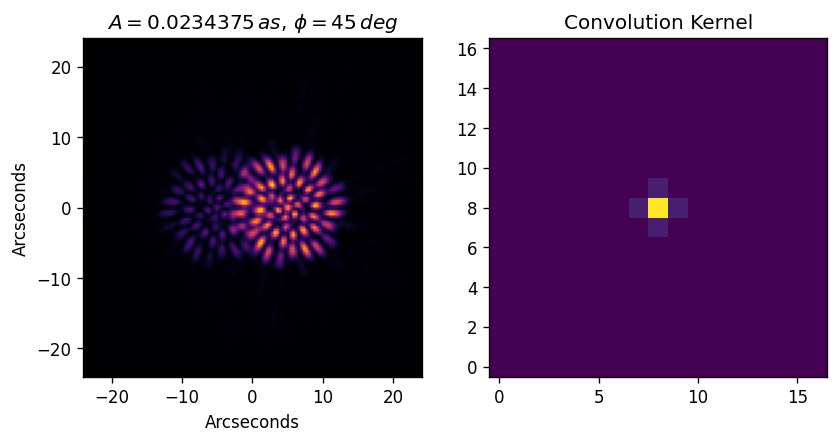

In [ ]:
show_jitter_example(telescope, effect_lim, 45)